In [39]:
%load_ext autoreload
%autoreload 2

%gui qt

import numpy as np
import numba as nb
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import napari
from pathlib import Path
import vrExperiment as vre
import vrFunctions as vrf
import basicFunctions as bf
import uiPlottingFunctions as uipf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# Code Needs: (eventually)
# - ROICaT index alignment tools (will wait until I have data processed and loaded from multiple sessions)

In [3]:
# Immediate next steps for programming work:

# - red cell processing functions
# - database development


In [54]:
# vrExperiment registration and preprocessing 
mouseName = 'ATL020'
dateString = '2023-05-04'
session = '702'
vrReg = vre.vrExperimentRegistration(mouseName, dateString, session, oasis=False, imaging=True)
vrReg.doPreprocessing()
vrReg.saveParams()
print(vrReg.sessionPath())
del vrReg

In session: ATL020/2023-05-04/702, vrFile['rigInfo'] does not exist. Assuming default settings for B2!
Self.value['numTrials'] set by trialInfo.trialIdx>0, but this might not be right. There might be smarter ways to determine which trials are 'good' trials...
frameSamples had 2 more than suite2p output. This happens sometimes. I don't like it. I think it's because scanimage sends a TTL before starting the frame
Facecam preprocessing has not been coded yet!
C:\Users\andrew\Documents\localData\ATL020\2023-05-04\702


In [55]:
mouseName = 'ATL020'
dateString = '2023-05-04'
session = '702'
vrexp = vre.vrExperiment(mouseName, dateString, session)

In [60]:
%%time
speedThreshold = 5
omap, smap, lickmap, distvec = vrf.getBehaviorMaps(vrexp,speedThreshold=speedThreshold) # produce smoothed occupancy and speed maps, along with the distance bins used to create them
frameTrialIdx, framePosition, frameSpeed = vrexp.getFrameBehavior() # convert behavioral data into timeframe of spiking data
spkmap = vrf.getSpikeMap(vrexp, frameTrialIdx, framePosition, frameSpeed, distvec, omap, speedThreshold=speedThreshold, standardizeSpks=False, doSmoothing=0) # produce the spkmap 
idxFullTrials = np.all(~np.isnan(omap),axis=1) # find out which trials the mouse explored the whole environment
relmse, relcor = vrf.measureReliability(spkmap[:,idxFullTrials], numcv=3) # measure reliability of spiking
spInfo = vrf.measureSpatialInformation(omap[idxFullTrials], spkmap[:,idxFullTrials]) # measure spatial information of spiking

CPU times: total: 3.19 s
Wall time: 565 ms


In [61]:
# red curation pipeline:
# write custom class for handling red data (maybe as part of vrExperiment?) -- (input is vrExp)
# write GUI function that opens the red handler -- (input is vrExp, creates the reddata object and a GUI)
# the GUI will then communicate between the user and the red cell handler!

# plan of attack: 
# - first, start with napari style GUI where reference image is overlaid by all ROIs that meet red cell criterion
# -------- use the four metrics, use double infinite lines to define the minimum and maximum value tolerated for red cells
# -------- never use grid mode...
# -------- create button to save selection criterion and classification output for each session independently

# - second, build scrollMatchedImages style GUI with a few extra selections... probably using a Qt Gui application rather than a pyqtgraph layout
# --------- for this, go through each ROI and optionally add manual annotation, which can be saved independently
# --------- it'll be nice to have mechanisms to choose which ROIs to look through, e.g. (1) in order red probability, (2) only red, (3) only ones with manual annotations, (4) etc.... 

# ---
# ---
# ---
# immediate next steps: 
# 1. write "computeDot"
# 2. write "computeCorr"
# 3. build napari interface
# 4. play with settings, probably try to integrate filter selection and correlation radius selection into the GUI

In [62]:
redCell = vre.redCellProcessing(vrexp)

redS2P = redCell.redS2P[redCell.roiPlaneIdx==planeIdx]
idxRedS2P = np.argsort(redS2P)[::-1]
useIdx = idxRedS2P[:30]

refStack, maskStack, pxcStack = redCell.croppedPhaseCorrelation(planeIdx=0)
window = uipf.scrollMatchedImages((refStack[idxRedS2P], maskStack[idxRedS2P], pxcStack[idxRedS2P]),enableMouse=True,preserveScale=True) 

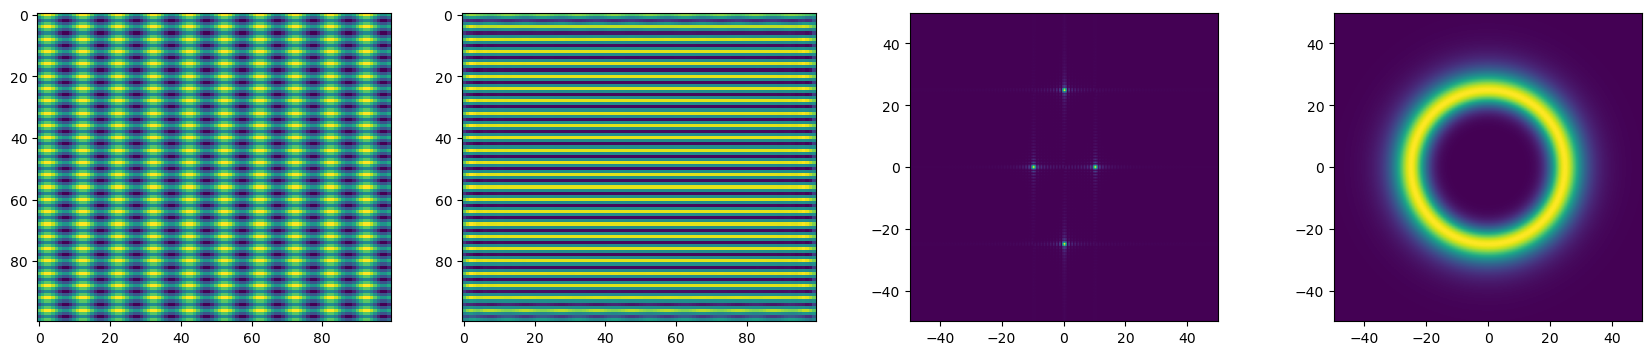

In [323]:
# code for testing bandpass butterworth filter I just implemented
N = 100
Ny,Nx = N,N
xx,yy = np.meshgrid(np.arange(Nx), np.arange(Ny))
fs = 100
xx = xx/fs
yy = yy/fs
lf = 10
hf = 25
im = np.sin(2*np.pi*xx*lf)+ 1*np.cos(2*np.pi*yy*hf) + 0*np.cos(2*np.pi*xx*hf)

lowcut = hf-0.5
highcut = hf+0.5
order = 5
fim, fftImage, bandpass, xfreq, yfreq = bf.butterworthbpf(im, lowcut, highcut, order=order, fs=fs)
xfxf = np.fft.fftfreq(2*Ny+1, 1/fs)

extent = (np.min(xfreq), np.max(xfreq), np.min(yfreq), np.max(yfreq))

fig,ax = plt.subplots(1,4,figsize=(21,4))
ax[0].imshow(im)
ax[0].set_aspect('auto')
ax[1].imshow(fim)
ax[1].set_aspect('auto')
ax[2].imshow(np.abs(fftImage), extent=extent)
# ax[2].set_xlim(-1,1)
# ax[2].set_ylim(hf-2, hf+2)
ax[3].imshow(np.abs(bandpass), extent=extent)
# ax[3].set_xlim(-1,1)
# ax[3].set_ylim(hf-2, hf+2)
plt.show()

255
(510, 510)
1.0


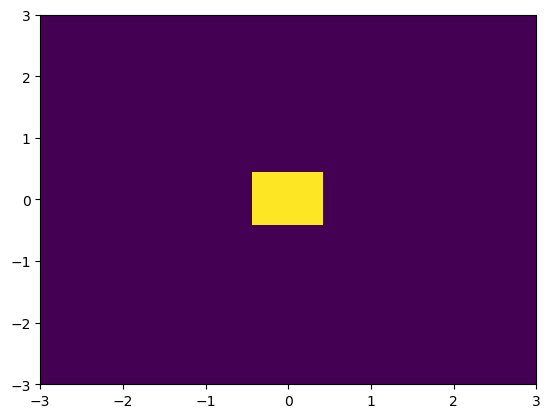

In [ ]:
# useful until I specifically code how to get the centered phase correlations into the redCellProcessing object

N = 510
center = int(N/2)
zeroPoint = int(np.floor(N/2))
print(zeroPoint)
useReference = redCell.reference[0][:N,:N]
print(useReference.shape)

numPixels = 3
pxcFull = bf.phaseCorrelation(useReference,useReference)
pxcCrop = pxcFull[zeroPoint-numPixels:zeroPoint+numPixels+1,zeroPoint-numPixels:zeroPoint+numPixels+1]
print(pxcFull[zeroPoint,zeroPoint])

plt.imshow(pxcCrop, extent=(-numPixels, numPixels, -numPixels, numPixels))
plt.gca().set_aspect('auto')
# plt.xlim(zeroPoint-5,zeroPoint+5)
# plt.ylim(zeroPoint-5,zeroPoint+5)
plt.show()
